# Setting up a restart file for regional dye tracer in MOM6

*Goal* : Including dye tracers in a MOM6 run that would be continued from a restart point.

*Requirements* : The tracer is expected to behave as a passive tracers that is released along the shore lines similiar to how cholorophyl blooms appear along she shlef regions. Higher concentrations along the shore and reducing concentration cross shelf.

*Whats needed* : A working MOM6 experiment setup, a compiled MOM6 model to run the experiment.

A restart file is needed to include the dye tracer into the existing experiment. Since you would want your restart file to have the grid correct, easiest way is to copy an existing resatrt file from a diferent tracer (salt,temp,etc..) and rewrite the atributes and values as needed.

To make sure I have all the attributes and the grid correct, I made a duplicate of my MOM6 run directory and ran from intialization with the Regional Dye included for few hours. This creates a restart file for the dye tracer. Then I change the vlaues in this restart file to represent the dye as per the requirement. Finally newly made/edited restart file is copied to the restart folder of the Original MOM6 run that I wish to continue. 

**Some of the restart files in the restart folder needs to be renamed since we are changing the number of restart files in the folder and disrupting the existing order of the files.**   

MOM6 restart files are named in the format of MOM.res_<no>.nc . The restart file for the dye tracer was MOM.res_11.nc in my experiment setup (not sure how the numbering would k for a different setup.)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40291 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40291/status,
Dashboard: /proxy/40291/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39273,Workers: 7
Dashboard: /proxy/40291/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:37719,Total threads: 2
Dashboard: /proxy/36899/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:39707,


### Open the restart file from the duplicate MOM6 run

In [3]:
MOM_restart = xr.open_dataset('/scratch/nm03/ae7501/mom6/archive/kimberly-reanalysis25/restart002/MOM.res_11.nc', decode_times=False) # xr will try to decode the time dimention and fail if decode_time= false is not set. time value in the restart file does not mathc the np date time setup.

In [4]:
MOM_restart

<xarray.Dataset> Size: 3GB
Dimensions:  (lath: 1285, lonh: 2611, Layer: 100, Time: 1)
Coordinates:
  * lath     (lath) float64 10kB -28.99 -28.97 -28.96 ... -7.043 -7.026 -7.009
  * lonh     (lonh) float64 21kB 96.01 96.03 96.05 96.06 ... 143.0 143.0 143.0
  * Layer    (Layer) float64 800B 2.465 7.407 12.37 ... 4.857e+03 5.452e+03
  * Time     (Time) float64 8B 7.386e+05
Data variables:
    dye001   (Time, Layer, lath, lonh) float64 3GB ...
Attributes:
    NumFilesInSet:  1

In [5]:
dye_restart = MOM_restart.dye001
dye_restart

<xarray.DataArray 'dye001' (Time: 1, Layer: 100, lath: 1285, lonh: 2611)> Size: 3GB
[335513500 values with dtype=float64]
Coordinates:
  * lath     (lath) float64 10kB -28.99 -28.97 -28.96 ... -7.043 -7.026 -7.009
  * lonh     (lonh) float64 21kB 96.01 96.03 96.05 96.06 ... 143.0 143.0 143.0
  * Layer    (Layer) float64 800B 2.465 7.407 12.37 ... 4.857e+03 5.452e+03
  * Time     (Time) float64 8B 7.386e+05
Attributes:
    long_name:  Dye Tracer 001
    units:      conc
    checksum:   36DD86B6EF1A8A92

In [6]:
print(np.isnan(MOM_restart.dye001).any())
# no nans 

<xarray.DataArray 'dye001' ()> Size: 1B
array(False)


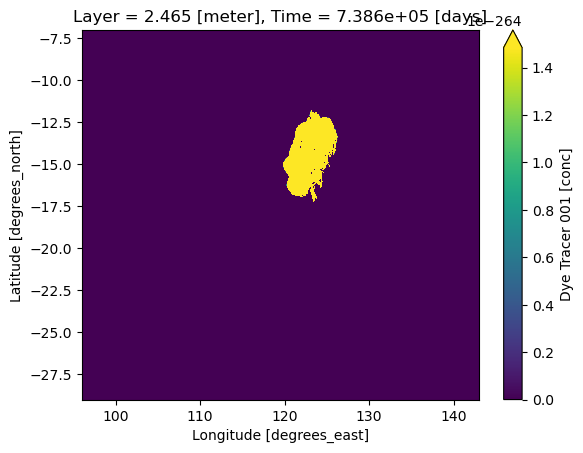

In [7]:
MOM_restart.dye001.isel(Time=0, Layer=0).plot(robust=True)

### Open the ocean stat file to create tracer data based on bathymentry

As my requirment was to spread the dye in a manner that looks like a chloropyl bloom, I use my bathymetry to recreate that spread. 

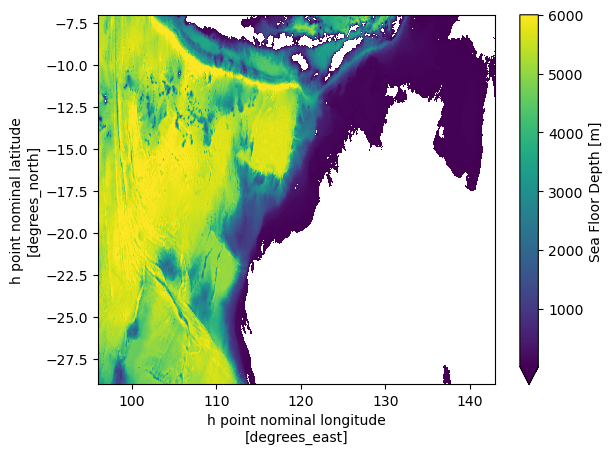

In [8]:
ocean_stat = xr.open_dataset('/scratch/nm03/ae7501/mom6/archive/kimberly-reanalysis24/output000/20230202.ocean_static.nc')
ocean_stat.deptho.plot(robust=True)

Change the values of the dye restart file to reflect the values from bathymetry

In [9]:
# The values of bathymetry are copied to all layers of the dye tracer restart.
for i in range(dye_restart.sizes["Layer"]):
  MOM_restart.dye001.data[0, i, ...] = ocean_stat.deptho

In [10]:
MOM_restart.dye001

<xarray.DataArray 'dye001' (Time: 1, Layer: 100, lath: 1285, lonh: 2611)> Size: 3GB
array([[[[3216.188477, ...,         nan],
         ...,
         [5221.214355, ...,         nan]],

        ...,

        [[3216.188477, ...,         nan],
         ...,
         [5221.214355, ...,         nan]]]])
Coordinates:
  * lath     (lath) float64 10kB -28.99 -28.97 -28.96 ... -7.043 -7.026 -7.009
  * lonh     (lonh) float64 21kB 96.01 96.03 96.05 96.06 ... 143.0 143.0 143.0
  * Layer    (Layer) float64 800B 2.465 7.407 12.37 ... 4.857e+03 5.452e+03
  * Time     (Time) float64 8B 7.386e+05
Attributes:
    long_name:  Dye Tracer 001
    units:      conc
    checksum:   36DD86B6EF1A8A92

normalize the values of the restart between 1 and 0

Next the dye concentration values needs to be between 0 and 1. Therefore the copied bathymetry values are normalized between 1 and 0. 

In [11]:
def normalize_xarray(var):
    var_min = var.min()  # Minimum value
    var_max = var.max()  # Maximum value

    normalized_var = (var - var_min) / (var_max - var_min)  # Scale between 0 and 1
    return normalized_var

# Example usage:
normalized_var = 1-normalize_xarray(MOM_restart.dye001)  

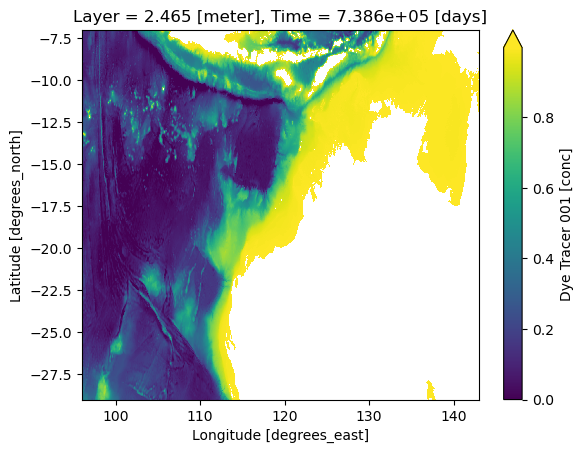

In [12]:
MOM_restart.dye001.values = normalized_var.values
MOM_restart.dye001.isel(Time=0,Layer=0).plot(robust =True)

add an exponential decay to the values to have higher concentration closer to the shore line and have lesser concentration as moving closer to the shelbreak

In [13]:

def exponential_decay(var, k):
    """Applies an exponential decay where values drop exponentially 
    as they move away from the max value.
    
    Parameters:
    - var: xarray.DataArray (the variable to normalize)
    - k: float (controls how fast values drop; higher values decay faster)
    
    Returns:
    - exponential_decay_var xarray.DataArray (values between 0 and 1)
    """
    var_max = var.max()
    
    # Apply exponential decay function
    exponential_decay_var = np.exp(-k * (var_max - var))
    
    return exponential_decay_var

# Example usage:
exponential_decay_var = exponential_decay(MOM_restart.dye001, k=15)  # Adjust k for desired decay


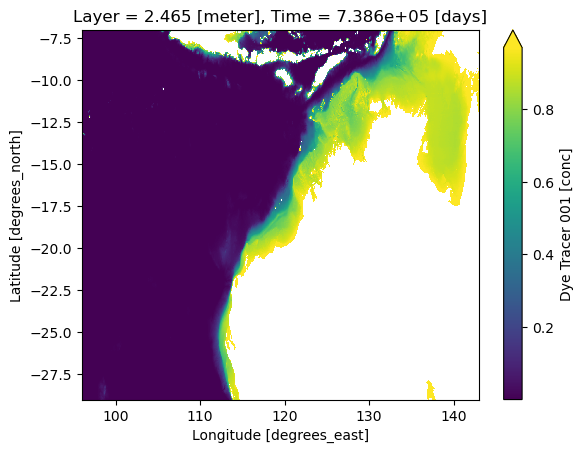

In [14]:
MOM_restart.dye001.values = exponential_decay_var.values
MOM_restart.dye001.isel(Time=0,Layer=0).plot(robust =True)

In [15]:
MOM_restart["dye001"] = MOM_restart["dye001"].fillna(0) # nan values cause the model to break. land mask is applied seperately during the model run. fill all nans with 0 

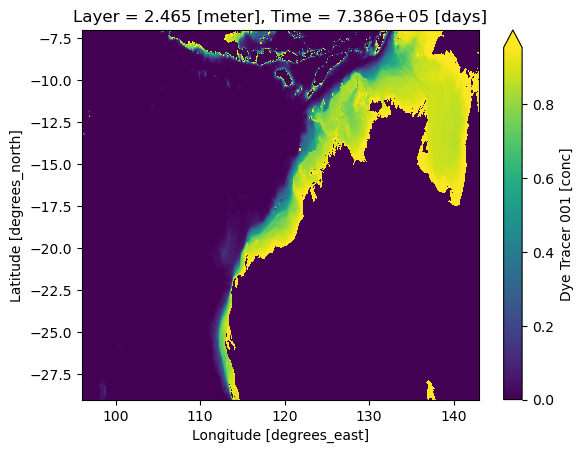

In [16]:
MOM_restart.dye001.isel(Time=0,Layer=0).plot(robust =True)

We need to change the time value of the newly created tracer restart file to match that of the restart files in the MOM6 restart folder that will be used to run the experiment. 
i.e. adjust the time stamp to mathch the initialization point. 

In [17]:
MOM_restart_1= xr.open_dataset('/scratch/nm03/ae7501/mom6/archive/kimberly-reanalysis24/restart011/MOM.res_1.nc', decode_times=False) # opena random restart file from the original experiment setup

In [18]:
MOM_restart_1

<xarray.Dataset> Size: 3GB
Dimensions:  (lath: 1285, lonh: 2611, Layer: 100, Time: 1)
Coordinates:
  * lath     (lath) float64 10kB -28.99 -28.97 -28.96 ... -7.043 -7.026 -7.009
  * lonh     (lonh) float64 21kB 96.01 96.03 96.05 96.06 ... 143.0 143.0 143.0
  * Layer    (Layer) float64 800B 2.465 7.407 12.37 ... 4.857e+03 5.452e+03
  * Time     (Time) float64 8B 7.387e+05
Data variables:
    Salt     (Time, Layer, lath, lonh) float64 3GB ...
Attributes:
    NumFilesInSet:  1

In [19]:
MOM_restart["Time"] = MOM_restart_1["Time"]

In [20]:
MOM_restart

<xarray.Dataset> Size: 3GB
Dimensions:  (lath: 1285, lonh: 2611, Layer: 100, Time: 1)
Coordinates:
  * lath     (lath) float64 10kB -28.99 -28.97 -28.96 ... -7.043 -7.026 -7.009
  * lonh     (lonh) float64 21kB 96.01 96.03 96.05 96.06 ... 143.0 143.0 143.0
  * Layer    (Layer) float64 800B 2.465 7.407 12.37 ... 4.857e+03 5.452e+03
  * Time     (Time) float64 8B 7.387e+05
Data variables:
    dye001   (Time, Layer, lath, lonh) float64 3GB 0.000324 0.0003254 ... 0.0
Attributes:
    NumFilesInSet:  1

### save the newly created restart nc file

In [21]:
MOM_restart.to_netcdf('/scratch/nm03/ae7501/mom6/archive/kimberly-reanalysis24/restart011/MOM.res_new.nc') #this file needs to be renamed as MOM.res_11.nc . 

Lets check if the file is properly saved

In [23]:
MOM_restart_chk= xr.open_dataset('/scratch/nm03/ae7501/mom6/archive/kimberly-reanalysis24/restart011/MOM.res_new.nc', decode_times=False) 

In [24]:
MOM_restart_chk

<xarray.Dataset> Size: 3GB
Dimensions:  (lath: 1285, lonh: 2611, Layer: 100, Time: 1)
Coordinates:
  * lath     (lath) float64 10kB -28.99 -28.97 -28.96 ... -7.043 -7.026 -7.009
  * lonh     (lonh) float64 21kB 96.01 96.03 96.05 96.06 ... 143.0 143.0 143.0
  * Layer    (Layer) float64 800B 2.465 7.407 12.37 ... 4.857e+03 5.452e+03
  * Time     (Time) float64 8B 7.387e+05
Data variables:
    dye001   (Time, Layer, lath, lonh) float64 3GB ...
Attributes:
    NumFilesInSet:  1

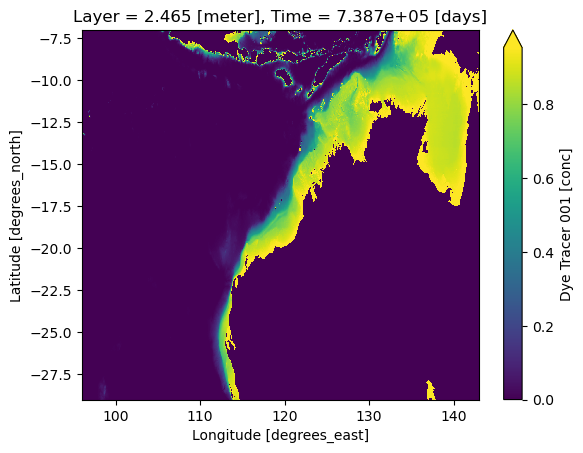

In [25]:
MOM_restart_chk.dye001.isel(Time=0, Layer=0).plot(robust=True)

In [27]:
print(np.isnan(MOM_restart_chk.dye001).any())

<xarray.DataArray 'dye001' ()> Size: 1B
array(False)
